In [137]:
import geopandas as gpd
import pandas as pd
import folium
import json
from folium import plugins
from IPython.display import display
from IPython.display import HTML, display
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import geojsonio
import io
import pickle
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import pyproj as proj
from pyproj import Transformer

from shapely.geometry import Point, Polygon

from shapely import geometry

mpl.style.use('ggplot')
print('libraries imported')

libraries imported


# Downloading and preparing dataset of underground location

In [160]:
df = pd.read_csv('C:/Users/amaur/OneDrive/Documents/Data science/MOOC/MOOC coursera/capstone/stations-de-metro.csv', sep=';', encoding='ISO-8859-1')
df.head()

,Geo Point,Geo Shape,NOM,LIGNE,Etat,Type,EN_SERVICE,COUVERT,COMMUNE
0,"43.5834842368,1.41513774085","{""type"": ""Point"", ""coordinates"": [1.4151377408...",MERMOZ,A,Existant,Metro,1993,Souterrain,TOULOUSE
1,"43.5933903494,1.41853757424","{""type"": ""Point"", ""coordinates"": [1.4185375742...",ARENES,A,Existant,Metro,1993,Souterrain,TOULOUSE
2,"43.6000809993,1.44393799548","{""type"": ""Point"", ""coordinates"": [1.4439379954...",ESQUIROL,A,Existant,Metro,1993,Souterrain,TOULOUSE
3,"43.5798543484,1.44211223005","{""type"": ""Point"", ""coordinates"": [1.4421122300...",EMPALOT,B,Existant,Metro,2007,Souterrain,TOULOUSE
4,"43.6006894932,1.45216998661","{""type"": ""Point"", ""coordinates"": [1.4521699866...",FRANCOIS VERDIER,B,Existant,Metro,2007,Souterrain,TOULOUSE


In [161]:
df = df[['Geo Point', 'LIGNE']]
df_metro = df[df.LIGNE!='C']
df_metro.reset_index(inplace=True)
df_metro.drop(['index'], axis=1, inplace=True)
df_metro.tail()

C:\Users\amaur\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Geo Point,LIGNE
33,"43.5797294461,1.45903160413",B
34,"43.6089939963,1.44521372372",B
35,"43.6203379173,1.43586470253",B
36,"43.6267449251,1.43396182427",B
37,"43.6379945515,1.44461246346",B


## Clean up geopoint (str) in a format that will be understandable for shapely transformation (float)

In [162]:
geo_point_list = df_metro['Geo Point'].tolist()

In [163]:
lat = []
long = []
for points in geo_point_list:
    lati = points.split(',')[0]
    lati = float(lati)
    longi = points.split(',')[1]
    longi = float(longi)
    lat.append(lati)
    long.append(longi)
df_metro['latitude']=lat
df_metro['longitude']=long

C:\Users\amaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\amaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


# Download the dataset from toulouse real estate value

In [164]:
toulouse = pd.read_csv('C:/Users/amaur/OneDrive/Documents/Data science/MOOC/MOOC coursera/capstone/data_toulouse_foncier.csv')
print('data loaded')

data loaded


# Generate the treatment variable treated is metro within a km radius

## Set up a geolocation projection system

In [165]:
# Setting the crs
transformer = Transformer.from_crs("epsg:4326", "epsg:2154")

## Project the coordinate on a plan given the chosen projection system

In [166]:
# For the toulouse real estate dataset
i=0
p=[]
while i<len(toulouse):
    long = transformer.transform(toulouse['longitude'][i], toulouse['latitude'][i])[0]
    lat = transformer.transform(toulouse['longitude'][i], toulouse['latitude'][i])[1]
    point = Point(long,lat)
    p.append(point)
    i=i+1

In [167]:
#for the metro location dataset
i=0
q=[]
while i<len(df_metro):
    long = transformer.transform(df_metro['longitude'][i], df_metro['latitude'][i])[0]
    lat = transformer.transform(df_metro['longitude'][i], df_metro['latitude'][i])[1]
    point = Point(long,lat)
    q.append(point)
    i=i+1

## Check if the observations are within a range between 100 m and 1,5 Km of a metro station and append these new treatment variables to the dataset of toulouse real estate

In [168]:
distances = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
i=0
distance_presence = []
while i<len(distances):
    outside_loop = []
    for points in p:
        inside = []
        for qoints in q:
            circle_buffer = qoints.buffer(distances[i])
            if points.within(circle_buffer):
                inside.append('True')
            else:
                inside.append('False')
        outside_loop.append(inside)
    presence_metro = []
    for lists in outside_loop:
        if 'True' in lists:
            presence_metro.append(1)
        else:
            presence_metro.append(0)
    distance_presence.append(presence_metro)
    print(i)
    i=i+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [169]:
i=0
while i<len(distance_presence):
    toulouse['distance_'+str(distances[i])] = distance_presence[i]
    i=i+1
toulouse.drop(['Unnamed: 0'], axis=1, inplace=True)
toulouse.head()

,valeur_fonciere,nom_commune,code_postal,id_parcelle,nombre_pieces_principales,surface_terrain,type_local,surface_reelle_bati,longitude,latitude,...,distance_600,distance_700,distance_800,distance_900,distance_1000,distance_1100,distance_1200,distance_1300,distance_1400,distance_1500
0,73000,Toulouse,31000,31555818AB0043,1,NaN,Appartement,17.0,1.438402,43.602411,...,0,0,0,1,1,1,1,1,1,1
1,140000,Toulouse,31200,31555831BC0687,4,225.0,Maison,77.0,1.446339,43.644810,...,0,0,0,0,0,1,1,1,1,1
2,76000,Toulouse,31400,31555813AD0294,0,NaN,Appartement,12.0,1.445320,43.586255,...,1,1,1,1,1,1,1,1,1,1
3,90000,Toulouse,31000,31555818AB0732,2,NaN,Appartement,30.0,1.440546,43.601473,...,1,1,1,1,1,1,1,1,1,1
4,350057,Toulouse,31000,31555827AD0187,3,90.0,Maison,59.0,1.425701,43.607076,...,0,0,0,0,0,0,0,0,0,0


# Data cleaning and formating

## Deleting missing values and 0 (corresponding to gift or heritage) from the dependant variable prior to analysis

In [172]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in toulouse.columns if toulouse[var].isnull().sum() > 0]

# determine percentage of missing values
toulouse[vars_with_na].isnull().mean()

surface_terrain    0.441059
dtype: float64

In [171]:
# building a boolean approach
droping = (toulouse['prix_m2'].isnull()) | (toulouse['prix_m2'] == 0)
toulouse = toulouse.loc[~droping]
toulouse.reset_index(inplace=True)
toulouse.drop(['index'], axis=1, inplace=True)
toulouse.head()

,valeur_fonciere,nom_commune,code_postal,id_parcelle,nombre_pieces_principales,surface_terrain,type_local,surface_reelle_bati,longitude,latitude,...,distance_600,distance_700,distance_800,distance_900,distance_1000,distance_1100,distance_1200,distance_1300,distance_1400,distance_1500
0,73000,Toulouse,31000,31555818AB0043,1,NaN,Appartement,17.0,1.438402,43.602411,...,0,0,0,1,1,1,1,1,1,1
1,140000,Toulouse,31200,31555831BC0687,4,225.0,Maison,77.0,1.446339,43.644810,...,0,0,0,0,0,1,1,1,1,1
2,76000,Toulouse,31400,31555813AD0294,0,NaN,Appartement,12.0,1.445320,43.586255,...,1,1,1,1,1,1,1,1,1,1
3,90000,Toulouse,31000,31555818AB0732,2,NaN,Appartement,30.0,1.440546,43.601473,...,1,1,1,1,1,1,1,1,1,1
4,350057,Toulouse,31000,31555827AD0187,3,90.0,Maison,59.0,1.425701,43.607076,...,0,0,0,0,0,0,0,0,0,0


## Checking the continuous variables - if the distribution is not normal we will log them (having the additional advantage to allow for a future effect interpretation in percents)

In [173]:
cont_var = ['surface_reelle_bati','prix_m2','surface_terrain','valeur_fonciere']

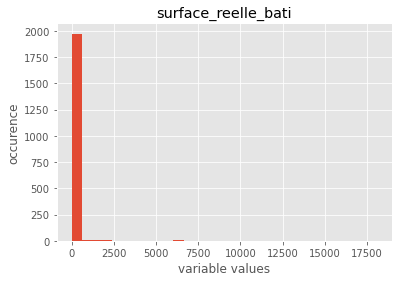

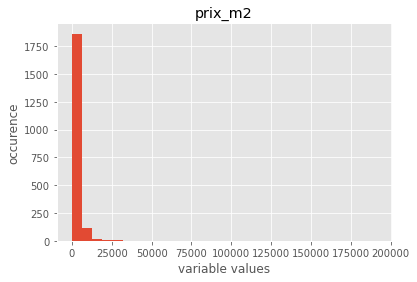

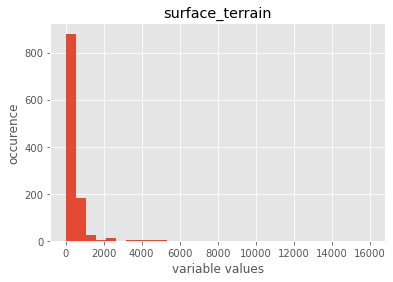

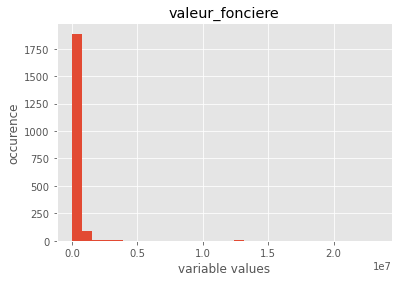

In [174]:
i=0
while i<len(cont_var):
    toulouse[cont_var[i]].hist(bins=30)
    plt.ylabel('occurence')
    plt.xlabel('variable values')
    plt.title(cont_var[i])
    plt.show()
    i=i+1

### Check for outliers

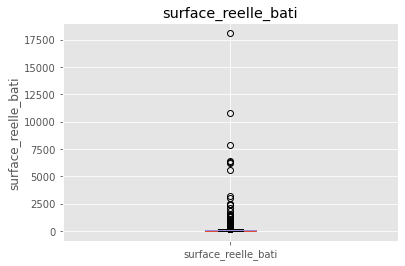

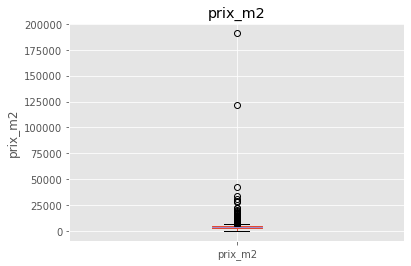

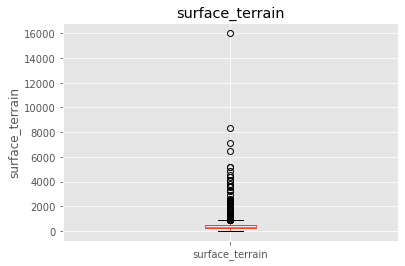

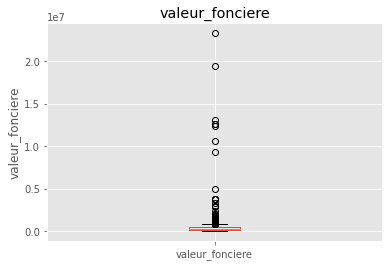

In [175]:
for var in cont_var:
        toulouse.boxplot(column=var)
        plt.title(var)
        plt.ylabel(var)
        plt.show()

### We see a great quantity of outliers, as we will try to match data to counterfactual it would be good practice to stream these outliers

In [176]:
Q1 = toulouse[cont_var].quantile(0.25)
Q3 = toulouse[cont_var].quantile(0.75)
IQR = Q3 - Q1

toulouse = toulouse[~((toulouse[cont_var] > (Q3 + 1.5 * IQR))).any(axis=1)]

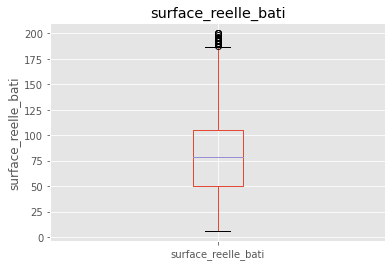

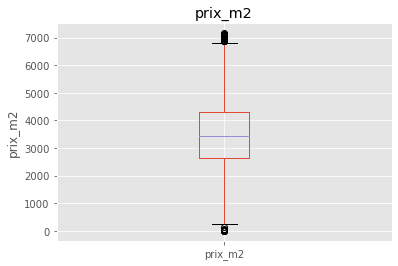

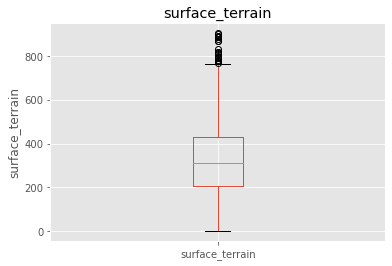

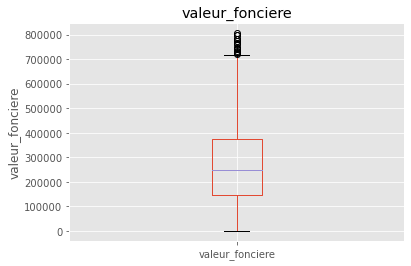

In [177]:
for var in cont_var:
        toulouse_without_outlier.boxplot(column=var)
        plt.title(var)
        plt.ylabel(var)
        plt.show()

## Checking categorical variables

In [178]:
## Distinction center VS the rest
centre = ['CAPITOLE', 'AMIDONNIERS','SAINT-GEORGES', 'MATABIAU','SAINT-AUBIN - DUPUY','CARMES', 'LES CHALETS',
         'COMPANS', 'ARNAUD BERNARD','LE BUSCA','SAINT-CYPRIEN']
exterieur = ['CROIX-DAURADE','SAINT-MICHEL','LA TERRASSE','MARENGO - JOLIMONT','SAINT-ETIENNE','POUVOURVILLE',
            'LES IZARDS', 'GUILHEMERY','SEPT DENIERS','PONT-DES-DEMOISELLES', 'COTE PAVEE', 'LALANDE', 'MINIMES', 'ROSERAIE',
            'SAINT-AGNE', 'SOUPETARD', 'SAUZELONG - RANGUEIL', "CHATEAU-DE-L'HERS", 'BARRIERE-DE-PARIS', 'MONTAUDRAN - LESPINET',
            'BONNEFOY', 'RANGUEIL - CHR - FACULTES', 'JULES JULIEN', 'GRAMONT', 'JUNCASSE - ARGOULETS', 'EMPALOT', 
            'GINESTOUS', 'LES PRADETTES', 'BELLEFONTAINE', 'CASSELARDIT', 'LA FOURGUETTE', 'FER-A-CHEVAL', 'SAINT-SIMON',
            'PAPUS', 'PURPAN', 'LA CEPIERE', 'LARDENNE', "PATTE D'OIE", 'CROIX-DE-PIERRE', 'MIRAIL-UNIVERSITE', 'SAINT-MARTIN-DU-TOUCH',
            'BASSO-CAMBO', 'FONTAINE-LESTANG', "ZONES D'ACTIVITES SUD", 'BAGATELLE', 'REYNERIE', 'FAOURETTE', 'ARENES']
## Appending to dataset
quartiers = toulouse['quartier']
zone = []
for quartier in quartiers:
    if quartier in centre:
        zone.append(1)
    else:
        zone.append(0)
toulouse['grande_zone'] = zone

In [187]:
toulouse['type_local'].unique()

array([0, 1], dtype=int64)

In [183]:
toulouse.drop(toulouse[toulouse.type_local == 'Local industriel. commercial ou assimilé'].index, inplace=True)

In [186]:
cleanup_types = {"type_local":{"Maison": 1, "Appartement": 0}}
def encode_dep(df):
    df.replace(cleanup_types, inplace=True)
encode_dep(toulouse)

# Start the Rubin modelling

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from causalinference import CausalModel

# Objectif : estimer le saut dans les prix immobiliers due à la présence d'une bouche de métro à proximité

## Problem : a set of assumption must be made so that we are sure that the effects comes from the treatment (i.e: the proximity of a subway station) and not from other covariates (size, presence of a gardern, nuber of rooms, neighborhood...)

To check that we must ensure 1 major thing: that the tratment is independant of the covariate (as an easily understandable example imagine that there are only manors next to the metro station and crubling rat hole far away from the metro station, how would you know if the difference in price is due to the presence of the transportation commodity or to the intrinsec quality of the house?). This is called the Conditional Independance Assumption.

Mathematically we have $(Y_0,Y_1)\perp T|X$

We want to estimate $\Delta = E[Y_1-Y_0] (1)$

However what we can have from the data is : $E[Y_1|T_{=1}]-E[Y_0|T_{=0}]$ which equals (1) if and only if $E[Y_i|D_i] = E[Y_i]$

### Define a set of treatment variables function of the distance to a metro subway

In [218]:
treats = ['distance_400','distance_500', 'distance_600', 'distance_700'
        , 'distance_800', 'distance_900', 'distance_1000', 'distance_1100', 'distance_1200', 'distance_1300']

### Check if there is a global difference in the outcome mean according to the treatment or control groups
Check $\Delta = E[Y_1-Y_0]$

In [219]:
for treat in treats:
    print(toulouse.groupby(treat)['prix_m2'].agg(['median','mean']))

                   median         mean
distance_400                          
0             3396.022727  3522.680754
1             3972.758621  3981.884560
                   median         mean
distance_500                          
0             3333.333333  3489.197360
1             3948.369565  3951.955318
                   median         mean
distance_600                          
0             3300.000000  3447.396243
1             3942.519201  3940.564528
                   median         mean
distance_700                          
0             3277.772148  3428.176876
1             3924.242424  3900.650423
                   median         mean
distance_800                          
0             3271.527778  3408.250467
1             3910.912500  3871.005510
                   median         mean
distance_900                          
0             3225.494253  3392.669595
1             3894.736842  3847.820808
                    median         mean
distance_1000           

We see that we have a difference in the conditional mean between the two groups with higher both median and mean values for the treated, if the CIA holds we will be able to attribute it to the presence of our metro station. Note that the means are constantly higher than the median which tels us that the distribution is skewed on the right() this is consistant with the outlier structure that we have seen in the data exploration phase.

### Let us check more in details the difference means disantagled by the independant variable

The normalized difference is set up as 
$\frac{E[X_t]-E[X_c]}{\sqrt{Std_t - Std_c}}$

In [220]:
for treat in treats:
    causal = CausalModel(Y=toulouse['prix_m2'].values, D=toulouse[treat].values, X=toulouse[['nombre_pieces_principales', 'surface_terrain', 'grande_zone', 'surface_reelle_bati',
                                                                                            'type_local']].values)
    print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=1389)         Treated (N_t=286)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y     3522.681     1227.130     3981.885     1264.315      459.204

                      Controls (N_c=1389)         Treated (N_t=286)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        3.666        1.512        2.566        1.454       -0.741
             X1          nan          nan          nan          nan          nan
             X2        0.196        0.397        0.545        0.499        0.776
             X3       83.974       38.706       61.972       38.398       -0.571
             X4        0.650        0.477        0.206        0.405       -1.003


Summ

The sample is balanced as far at it regards the nuber of rooms in the accomodation and the size in m2 of the accomodation. However more appartment appears in the treated group (this is due to the number of appartment that you can put on a single location point or to the density of both selling and metro stops in the city center) conversely accomodation is greater area are in the tratment group (again probably due to density of habitation and metro lines matter)

### We can have a more visual apect of the problem by checking if distributions overlap
for few var and treatment distance (a global graph would be intractable leading to 5*10 graphs)

distance_1100
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: nombre_pieces_principales, dtype: object

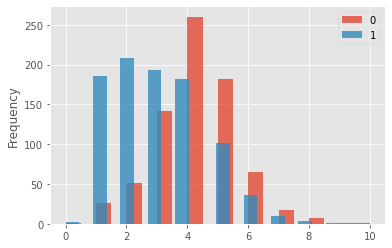

In [212]:
toulouse.groupby('distance_1100')['nombre_pieces_principales'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

### The strategy to tackle this problem will be to assign a chance of being ''treated'' according to the whole covariate vector and not variable by variables individually. This will be done by a Probit regression we will estimate what a Propensity score of being treated.
The math logic is as follow $s(X) = P(T_{=1}|X) = \frac{\exp{X}}{1+\exp{X}}$

So the closest it is to 0.5 the best the CIA should be

In [221]:
for treat in treats:
    causal = CausalModel(Y=toulouse['prix_m2'].values, 
                         D=toulouse[treat].values, 
                         X=toulouse[['nombre_pieces_principales', 'grande_zone', 'surface_reelle_bati', 'type_local']].values)
    #causal.stratify_s()
    #print(causal.strata)
    causal.est_propensity_s()
    print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -0.880      0.188     -4.680      0.000     -1.249     -0.512
            X3     -1.384      0.219     -6.320      0.000     -1.813     -0.955
            X1      0.697      0.160      4.364      0.000      0.384      1.011
            X0     -0.345      0.104     -3.324      0.001     -0.548     -0.141
            X2      0.009      0.004      2.510      0.012      0.002      0.017


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -0.061      0.241     -0.252      0.801     -0.533      0.412
            X3     -0.417      0.494     -0.844      0.399     -1.386      0.552
            X1      0.

### Estimate the average effect of the treatment 

In [222]:
for treat in treats:
    causal = CausalModel(Y=toulouse['prix_m2'].values, 
                         D=toulouse[treat].values, 
                         X=toulouse[['nombre_pieces_principales', 'grande_zone', 'surface_reelle_bati', 'type_local']].values)
    causal.est_via_matching(bias_adj=True, matches = 5)
    print(causal.estimates)

C:\Users\amaur\Anaconda3\lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    141.581    112.199      1.262      0.207    -78.329    361.491
           ATC    124.254    123.783      1.004      0.315   -118.362    366.869
           ATT    225.733     94.342      2.393      0.017     40.822    410.644


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    258.170     91.623      2.818      0.005     78.589    437.752
           ATC    248.861    103.684      2.400      0.016     45.641    452.082
           ATT    287.361     86.170      3.335      0.001    118.467    456.255


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Co

In [231]:
ATE  = [141, 258, 272, 228, 214, 220, 228, 237, 186, 241]

In [233]:
distance = [400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300]

Text(0.5, 0, '[400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300]')

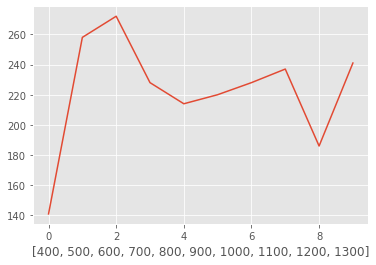

In [234]:
plt.plot(ATE)
plt.xlabel(distance)